In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows=10
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [6.3,4.7]
import iso3166 # Country codes to translate between ecdc and UN population figures
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy import signal
import scipy.special as sps

In [2]:
filename="COVID-19-geographic-disbtribution-worldwide-2020-04-28.xlsx"
URL_base="https://www.ecdc.europa.eu/sites/default/files/documents/"
URL=URL_base+filename

!wget $URL -nc --no-proxy

File ‘COVID-19-geographic-disbtribution-worldwide-2020-04-28.xlsx’ already there; not retrieving.



In [3]:
# Ingest ECDC data
ecdc=pd.read_excel(filename)
# Fix some idiosnycrasies in ECDC dataset
ecdc.loc[ecdc.geoId=="EL", ['geoId']]="GR" # Greece geoId is set as "EL". This is WRONG, iso3166 says it's "GR"
ecdc.loc[ecdc.geoId=="UK", ['geoId']]="GB" # UK geoId is set as "UK". This is WRONG, iso3166 says it's "GB"
ecdc.drop(ecdc[ecdc['geoId']=='GG'].index, inplace=True) # Drop weird places w/o iso3166 code: Guernsey
ecdc.drop(ecdc[ecdc['geoId']=='JE'].index, inplace=True) # Drop weird places w/o iso3166 code: Jersey
ecdc.drop(ecdc[ecdc['geoId']=='XK'].index, inplace=True) # Drop weird places w/o iso3166 code: Kosovo
ecdc.drop(ecdc[ecdc['geoId']=='AN'].index, inplace=True) # Drop weird places w/o iso3166 code: Netherlands Antilles
ecdc.drop(ecdc[ecdc['geoId']=='JPG11668'].index, inplace=True) # Drop weird places w/o iso3166 code: Cruise Ship
ecdc.drop(ecdc[ecdc['geoId']=='AD'].index, inplace=True) # Drop weird places w/o Population data: Andorra
ecdc.drop(ecdc[ecdc['geoId']=='AI'].index, inplace=True) # Drop weird places w/o Population data: Anguila
ecdc.drop(ecdc[ecdc['geoId']=='BM'].index, inplace=True) # Drop weird places w/o Population data: Bermuda
ecdc.drop(ecdc[ecdc['geoId']=='VG'].index, inplace=True) # Drop weird places w/o Population data: British Virgin Islands
ecdc.drop(ecdc[ecdc['geoId']=='KY'].index, inplace=True) # Drop weird places w/o Population data: Cayman Islands
ecdc.drop(ecdc[ecdc['geoId']=='DM'].index, inplace=True) # Drop weird places w/o Population data: Dominica
ecdc.drop(ecdc[ecdc['geoId']=='FK'].index, inplace=True) # Drop weird places w/o Population data: Falkland Islands
ecdc.drop(ecdc[ecdc['geoId']=='FO'].index, inplace=True) # Drop weird places w/o Population data: Faroe Islands
ecdc.drop(ecdc[ecdc['geoId']=='GI'].index, inplace=True) # Drop weird places w/o Population data: Gibraltar
ecdc.drop(ecdc[ecdc['geoId']=='GL'].index, inplace=True) # Drop weird places w/o Population data: Greenland
ecdc.drop(ecdc[ecdc['geoId']=='VA'].index, inplace=True) # Drop weird places w/o Population data: Holy See / Vatican
ecdc.drop(ecdc[ecdc['geoId']=='IM'].index, inplace=True) # Drop weird places w/o Population data: Isle of Man
ecdc.drop(ecdc[ecdc['geoId']=='LI'].index, inplace=True) # Drop weird places w/o Population data: Liechtenstein
ecdc.drop(ecdc[ecdc['geoId']=='MC'].index, inplace=True) # Drop weird places w/o Population data: Monaco
ecdc.drop(ecdc[ecdc['geoId']=='MS'].index, inplace=True) # Drop weird places w/o Population data: Montserrat
ecdc.drop(ecdc[ecdc['geoId']=='MP'].index, inplace=True) # Drop weird places w/o Population data: Northern Mariana Islands
ecdc.drop(ecdc[ecdc['geoId']=='KN'].index, inplace=True) # Drop weird places w/o Population data: Saint Kitts and Nevis
ecdc.drop(ecdc[ecdc['geoId']=='SM'].index, inplace=True) # Drop weird places w/o Population data: San Marino
ecdc.drop(ecdc[ecdc['geoId']=='SX'].index, inplace=True) # Drop weird places w/o Population data: Sint Maarten
ecdc.drop(ecdc[ecdc['geoId']=='TC'].index, inplace=True) # Drop weird places w/o Population data: Turks and Caicos Islands


Countries=ecdc[['geoId', "countriesAndTerritories"]].drop_duplicates().set_index("geoId").rename(columns={"Countries and territories":"Country"})
# Countries=Countries.Country.str.replace('_',' ').str.replace('United States of America','USA').str.replace('United Kingdom','UK')

# Create more useful DataFrames out of ECDC set:
# Number of reported cases and cumsum of reported cases
cases=ecdc.pivot(index="dateRep", columns="geoId", values="cases").fillna(0)
Ncases=cases.cumsum()
# Number of reported deaths and cumsum of reported deaths
deaths=ecdc.pivot(index="dateRep", columns="geoId", values="deaths").fillna(0)
Ndeaths=deaths.cumsum()

In [4]:
try:
    Population=pd.read_csv('Population.csv').set_index('geoId')
    Population=Population.iloc[:,0] # Convert from DataFrame to Series, to be able to divide all rows with it!
    Age_distribution=pd.read_csv('Age_distribution.csv')
    Age_distribution.set_index('geoId', inplace=True)
    Age_distribution=Age_distribution.T
except IOError:
    print('Population/Age distribution cache not found')
    !wget "https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F07_1_POPULATION_BY_AGE_BOTH_SEXES.xlsx" -nc --no-proxy
    print("reading giant UN population excel")
    wpp=pd.read_excel("WPP2019_POP_F07_1_POPULATION_BY_AGE_BOTH_SEXES.xlsx")
    print("shuffling data")
    wpp=wpp.iloc[:,np.r_[4,7,8:29]] # select cols with country code and pop by age
    wpp.columns=['LocID', 'Year', '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
    wpp.query("Year==2020", inplace=True) # drop all but year 2020 data
    wpp.drop(['Year'], axis=1, inplace=True) # get rid of year colum
    wpp.set_index('LocID', inplace=True)

    # re-bin UN data to same age bins as used by Verity et al.
    Age_distribution=wpp.groupby([ 1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9, 9, 9, 9, 9], axis=1).sum()
    Age_distribution.columns=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
    # Didn't find a more pythonesque way to translate numerical country LocId to 2-letter geoId using iso3166
    # Hence looping over all Countries in ecdc dataset and setting geoId.
    # Marking with NaN before, so we can drop everything that is not in ecdc in one go
    Age_distribution['geoId']=np.nan
    for geoId in Countries.index.drop_duplicates():
        if not np.isreal(geoId) and len(geoId)==2:
            LocID=np.int(iso3166.countries_by_alpha2[geoId].numeric)
            Age_distribution.loc[[LocID],['geoId']]=geoId

    Age_distribution.dropna(inplace=True)
    Age_distribution.set_index('geoId', inplace=True)

    # Sum over population in all age brackets to get total population
    Population=pd.DataFrame({'Population': Age_distribution.sum(axis=1), 'geoId': Age_distribution.index})
    Population.set_index('geoId', inplace=True)

    Population.to_csv('Population.csv')  # save to cache
    Population=Population.iloc[:,0] # Convert from DataFrame to Series, to be able to divide all rows with it!
    # Population in units of Millions

    # Normalise age bracket populations with total population to get population distribution
    Age_distribution=(Age_distribution.T/Population)
    Age_distribution.T.to_csv('Age_distribution.csv') # save to cache

Population/=1000

In [5]:
# Some data taken from a recent study: Verity et al. (2020), Lancet Infect Dis 2020,
# Estimates of the severity of coronavirus disease 2019: a model-based analysis
# https://doi.org/10.1016/S1473-3099(20)30243-7
# Case fatality, infection fatality and hospitalisation
Outcome_ratio=pd.DataFrame({'Infection fatality': np.array([0.00161, 0.00695, 0.0309, 0.0844, 0.161, 0.595, 1.93, 4.28, 7.8])*1e-2,
                            'Case fatality': np.array([0.0026, 0.0148, 0.6, 0.146, 0.295, 1.25, 3.99, 8.61, 13.4])*1e-2,
                           'Hospitalisation': np.array([0, 0.0408, 1.04, 3.43, 4.25, 8.16, 11.8, 16.6, 18.4])*1e-2}).T
Outcome_ratio.columns=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
Outcome_ratio=Outcome_ratio.T
IFR=(Outcome_ratio['Infection fatality'].iloc[:]*Age_distribution.T).sum(axis=1)
CFR=(Outcome_ratio['Case fatality'].iloc[:]*Age_distribution.T).sum(axis=1)
HR=(Outcome_ratio['Hospitalisation'].iloc[:]*Age_distribution.T).sum(axis=1)

# PDF of recovery time and time to death, see Verity et al. results section
def pdf_recovery(t):
    # [...]
    # Using data on the outcomes of 169 cases reported outside of mainland China, 
    # we estimated a mean onset-to-recovery time of 24·7 days (95% CrI 22·9–28·1) 
    # and coefficient of variation of 0·35 (0·31–0·39; figure 2)
    mean=24.7 
    CV=.35 
    std=CV*mean
    theta=std**2/mean
    k=mean/theta
    return t**(k-1)*(np.exp(-t/theta) / (sps.gamma(k)*theta**k))

def pdf_death(t):
    # China early in the epidemic, with correction for bias introduced by the 
    # growth of the epidemic, we estimated the mean time from onset to death
    # to be 18·8 days (95% credible interval [CrI] 15·7–49·7; figure 2) with
    # a coefficient of variation of 0·45 (95% CrI 0·29–0·54).
    # [...]
    # However, given that the epidemic in China has since declined, our posterior
    # estimate of the mean time from onset to death, informed by the analysis of
    # aggregated data from China, is more precise (mean 17·8 days [16·9–19·2]; 
    CV=.45
    mean=17.8
    std=CV*mean
    theta=std**2/mean
    k=mean/theta
    return t**(k-1)*(np.exp(-t/theta) / (sps.gamma(k)*theta**k))


In [6]:
# Hospital beds for some countries
# Did not find consistent data source for worldwide numbers. So quickly collected some data manually
# from several sources
# https://ec.europa.eu/eurostat/web/products-datasets/-/tps00046
# https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds
#
Hbeds=pd.Series({'CN':6250000,
                 'US':924107,
                 'KR':630000,
                 'DE':661448,
                 'ES':138511,
                 'FR':399865,
                 'IT':192548,
                 'NL':56886,
                 'GB':167589,
                 'AT':64285,
                 'GR':50030,
                 'PL':250544,
                 'CZ':71000,
                 'SE':22400,
                 'BE':66800,
                 'PT':34600
                })
ICUbeds=pd.Series({'CN':52000,
                'US':115000,
                'KR':5430,
                'DE':24500,
                'ES':4500,
                'FR':7570,
                'IT':7560,
                'NL':1100,
                'GB':4500,
                'AT':1960,
                'GR':625,
                'PL':2600,
                'CZ':1240,
                'SE':580,
                'BE': 1840,
                'PT':430
                })

In [7]:
# Data filters and data mangling

# Countries of interes
# Interest=['DE', 'NL', 'IT', 'FR', 'ES', 'GB', 'US', 'CN', 'KR']
# Interest=['DE', 'NL', 'IT', 'FR', 'GB', 'ES', 'AT', 'CN', 'KR']
Interest=['US', 'NL', 'IT', 'FR', 'DE', 'ES', 'GB', 'BE', 'GR']

# time of interest
startdate=pd.Timestamp("2020-02-21")

# Number of cases since 100th case
# Found no way to shift columns with a column-individual shift, so:
# loop over all countries and extract data, then re-assemble as DataFrame
Ncase100=pd.DataFrame({'days':[]}).set_index('days') 
for geoId in Ncases:
    temp=Ncases[geoId].values[Ncases[geoId].values>100]
    temp=pd.DataFrame({"days": np.arange(len(temp)), geoId: temp}).set_index('days')
    Ncase100=Ncase100.join(temp, how='outer')

In [8]:
# Define DataFrame-compatible logistic functions to fit
def logistic_raw(x_in,a,b,c):
    # basic logisitc function, as needed for curve_fit
    x=np.array(x_in)
    return c/(1+np.exp(-(x-b)/a))

def logistic(x_in,p, name=None):
    # fancy-pants wrapper, can be called with DateFrame as input, detects if it's Ncases
    # or Ncase100 data, and shifts date to DoY2020 for Ncases. Detects DataFrame from df_fit as parameters
    # in hindsight probably would have been easier to simply write a bunch of classes instead of an
    # if..elif..else orgy :/
    if isinstance(x_in, pd.core.series.Series): # if called with a full DataFrame as input
        if x_in.index.name=='days': # if called with a full Ncase100 DataFrame as input
            x=x_in.dropna().index
            x_out=x_in.dropna().index
        elif x_in.index.name=='DateRep': # if called with a full DataFrame as input
            x=x_in.index.to_julian_date()-2458848.5 # DoY 2020, but as float - nb 2020-01-01 is DoY 1.
            x_out=x_in.index
    elif x_in.dtype=='int64': # if called with index of Ncase100 DataFrame as input
        x=x_in
        x_out=x_in
    elif x_in.dtype=='<M8[ns]': # if called with index of Ncases DataFrame as input
        x=x_in.to_julian_date()-2458848.5 # DoY 2020, but as float - nb 2020-01-01 is DoY 1.
        x_out=x_in
    else:
        x=x_in
        x_out=x_in
        
    if isinstance(p, tuple): # assume raw fit results as parameters, i.e. fitpar are in [0], cov in [1]
        p=p[0]
        
    if isinstance(p, pd.DataFrame): # translate human readable fitpars to par
        a=p['Fit']['k']
        if type(p['Fit']['t0'])==pd.Timestamp:
            b=p['Fit']['t0'].to_julian_date()-2458848.5
        else:
            b=p['Fit']['t0']
        c=p['Fit']['L']
    else:
        a=p[0]
        b=p[1]                                                          
        c=p[2]
    y=logistic_raw(x,a,b,c)
    return pd.DataFrame({name: y}, index=x_out)

In [9]:
# Fancy-pants wrapper for curve_fit(), can be called with DatFrame as input, detects if it's Ncases
# or Ncase100 data, shifts date to DoY2020 for Ncases, and creates nice readable DataFrame as fit result
def df_fit(fct, df_data, startp):
    # extract x-axis
    x_in=df_data.dropna().index
    if x_in.dtype=='int64':
        x=list(x_in.dropna())
    elif x_in.dtype=='<M8[ns]':
        x=list(x_in.to_julian_date()-2458848.5) # DoY 2020, but as float - nb 2020-01-01 is DoY 1.
    else:
        x=x_in
    
    # extract y-axis
    data=list(df_data.dropna().values)
    
    # fit!
    fitpar,cov=curve_fit(fct, x, data, startp)
    
    # estimate error from covariance matrix
    error=[np.sqrt(cov[i][i]) for i in np.arange(0,len(cov))]
    

    # assemble output DataFrame with fit parameters and errors
    if len(fitpar)==3:
        if x_in.dtype=='<M8[ns]': # Ncase, i.e. complete date given in x-axis
            d=pd.to_datetime("2020-01-01")+pd.to_timedelta(fitpar[1], unit='D')
            out=pd.DataFrame({'Fit':[fitpar[0], d, fitpar[2]], 'FitErr': error}, index=['k', 't0', 'L'])
        else: # Ncase100, i.e. day-number given in x-axis
            out=pd.DataFrame({'Fit':fitpar, 'FitErr': error}, index=['k', 't0', 'L'])
    else:
        out=fitpar
    return out

US detection rate fit: 9.7%+-1.4% (3sigma, statistical fit error only)
NL detection rate fit: 7.3%+-1.2% (3sigma, statistical fit error only)
IT detection rate fit: 9.3%+-1.5% (3sigma, statistical fit error only)
FR detection rate fit: 5.2%+-1.0% (3sigma, statistical fit error only)
DE detection rate fit: 25.1%+-2.2% (3sigma, statistical fit error only)
ES detection rate fit: 11.1%+-2.7% (3sigma, statistical fit error only)
GB detection rate fit: 5.1%+-0.9% (3sigma, statistical fit error only)
BE detection rate fit: 4.7%+-0.7% (3sigma, statistical fit error only)
GR detection rate fit: 22.5%+-5.5% (3sigma, statistical fit error only)


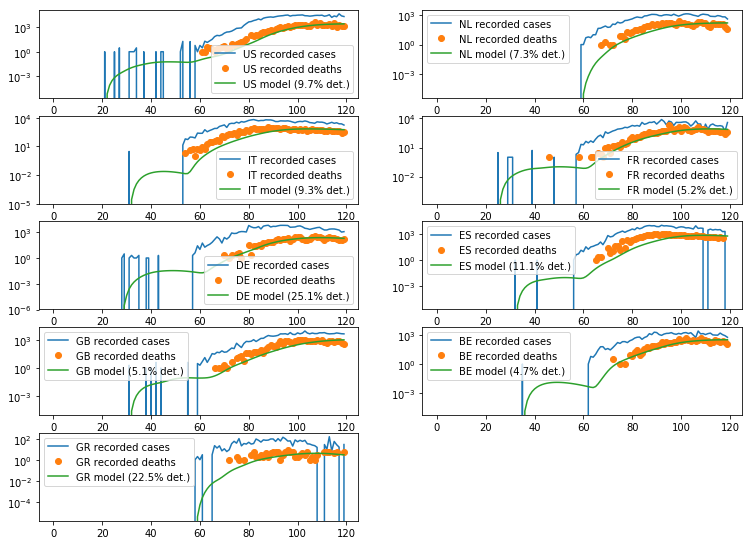

In [10]:
# Use assumption that it's easier to record deaths than to record cases to estimate the
# infection detection rate:
# First, use fatality Onset-to-death curve and Infection Fatality Rate to create a synthetic
# modelled fatality count. Onset-to-death effectively is a PDF, so we can just convolve
# the recorded cases with this PDF (normalised with IFR) to estimate number of deaths
# This estimate is going to be too low if cases were missed. Include a correction factor, and fit
# actually recorded fatalities to estimate this correction factor
# NB: this fit doesn't work well if detection changes, as eg in the case of Italy and Spain, where
# it appears health services were inundated and missed cases, and the detection rate started to
# recover as the cases per day reduced
fig=plt.figure(figsize=(6.3*2,4.7*2))

i=0
IDR=pd.DataFrame({'geoId':[], 'rate': []})
for C in Interest:
    i=i+1
    modeled_deaths=lambda t, DR: (signal.convolve(cases[C],IFR[C]*pdf_death(t)/DR)[0:len(cases[C])])
    pf=curve_fit(modeled_deaths, np.arange(0,len(deaths[C].index)) , deaths[C].values, .1)
    detr=pf[0][0]
    detr_err=np.sqrt(pf[1][0][0])
    
    fig.add_subplot(np.ceil(len(Interest)/2),2,i)
    plt.semilogy(cases[C].values)
    plt.semilogy(deaths[C].values, 'o')
    plt.semilogy(modeled_deaths(np.arange(0,len(cases[C].index)), detr))
    plt.legend(['{} recorded cases'.format(C),
                '{} recorded deaths'.format(C),
                '{} model ({:2.1%} det.)'.format(C, detr)
               ])
    print('{} detection rate fit: {:2.1%}+-{:2.1%} (3sigma, statistical fit error only)'.format(C, detr, detr_err*3) )
    IDR=IDR.append(pd.DataFrame({'geoId':[C], 'rate': [detr]}))
    
IDR=IDR.set_index('geoId').iloc[:,0]
infections=cases[Interest]/IDR[Interest] # Number of actual infections in country
Ninfections=Ncases[Interest]/IDR[Interest] # Number of actual total cumulative infections in country

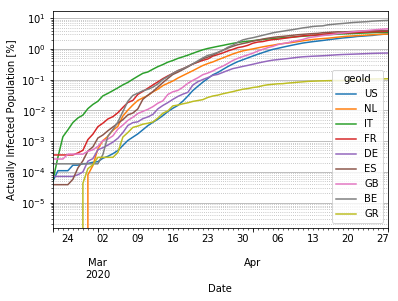

In [11]:
# Estimate actually infected percentage of population
# From this it seems like Germany and Austria have a 10x lower fraction
# of infected population compared to their neighbours. This is not
# really plausible. So maybe mortality is REALLY lower in DE and AT,
# and the differences are NOT all due to testing regimes?

p=(Ninfections[Interest]/(Population[Interest]*1e6)*100).plot(logy=True)
p.set_xlabel("Date")
p.set_ylabel("Actually Infected Population [%]")
p.grid('on', which='major', axis='y')
p.grid('on', which='minor', axis='y', linestyle='dotted')
p.set_xlim(startdate,);

In [12]:
# Data of above plot
Ninfections[Interest]/(Population[Interest]*1e6)*100

geoId,US,NL,IT,FR,DE,ES,GB,BE,GR
dateRep,,,,,,,,,
2019-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2020-04-24,2.716984,2.867851,3.362848,3.584725,0.714596,3.894155,4.027510,7.836046,0.104881
2020-04-25,2.783730,2.932546,3.416325,3.637337,0.724361,3.950641,4.184611,8.109961,0.106030
2020-04-26,2.935429,2.985121,3.458048,3.682946,0.732614,3.983815,4.327915,8.298918,0.106712


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp


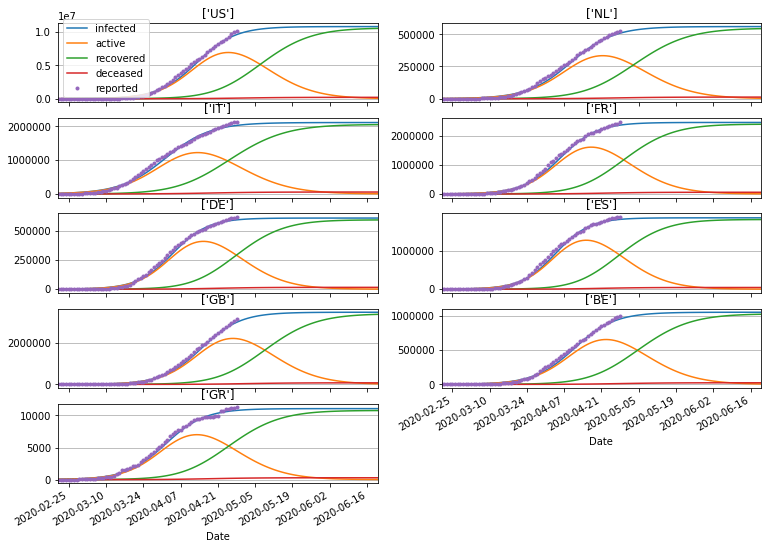

In [13]:
# Experiment with logistics fits to cases as fct of date
# NB predictions are shaky and dangerous! That's why the real epidemiologists don't
# go on record with simple logistics fits...
# Still:
# Use logistics fit to convolve with onset-to-recovery and onset-to-death curves
# Subtract recovery and death curves thus derived from logistics fit to get estimate
# of active cases

fig=plt.figure(figsize=(6.3*2,4.7*2))

i=0;
t=pd.date_range('2020-02-15', '2020-06-20')
tt=t.to_julian_date()-t[0].to_julian_date()
for geoId in Interest:
# for geoId in ['DE', 'US']:
    i+=1

#     ax=fig.add_subplot(np.ceil(len(Interest)/2),2,i, sharex=ax)
    ax=fig.add_subplot(np.ceil(len(Interest)/2),2,i)
    startpar=[5,30,max(Ninfections[geoId])]
    pf=df_fit(logistic_raw, Ninfections[geoId], startpar)
    infection_model=logistic(t, pf, geoId)
    fatality_model=signal.convolve(infection_model.values[:,0], CFR[geoId]*pdf_death(tt))[0:len(t)]
    recovered_model=signal.convolve(infection_model.values[:,0], (1-CFR[geoId])*pdf_recovery(tt))[0:len(t)]
    active_model=infection_model.values[:,0]-(fatality_model+recovered_model)
    hospital_model=active_model*HR[geoId]
    
#     infection_model.plot(ax=ax, logy=True)
#     fatality_model.plot(ax=ax, logy=True)
#     recovered_model.plot(ax=ax, logy=True)
#     active_model.plot(ax=ax, logy=True)

    ax.plot(
         t, infection_model,
         t, active_model,
#          t, hospital_model,
         t, recovered_model,
         t, fatality_model,
#         t[[0,1]],[Hbeds['DE'], Hbeds['DE']]
        )
    Ninfections[geoId].plot(ax=ax, logy=False, style='.', label=geoId)
#     ax.plot(t[[0,-1]],[Hbeds[geoId], Hbeds[geoId]])
    ax.set_xlim(startdate,)
    ax.set_xlabel("Date")
    ax.set_title([geoId])
#     ax.legend([
#         'infections',
#         'active',
#         'recovered',
#         'deceased',
#         'reported'
#     ])

    if i==1:
        ax.legend([
            'infected',
            'active',
            'recovered',
            'deceased',
            'reported'
        ])

    if i>=len(Interest)-1:
        ax.set_xlabel("Date")
    else:
        ax.set_xticklabels([])
        ax.set_xlabel("")

#     ax.set_ylabel('cases');
    ax.grid('on', which='major', axis='y')
    
# ax.set_ylabel("Total infections with logistic fit")
# ax.grid('on', which='major', axis='y')
# ax.grid('on', which='minor', axis='y', linestyle='dotted')

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp


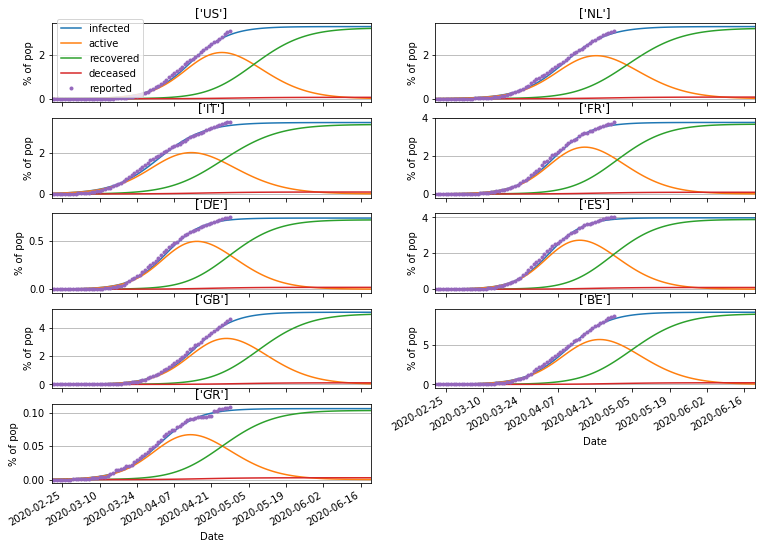

In [14]:
# Experiment with logistics fits to cases as fct of date
# NB predictions are shaky and dangerous! That's why the real epidemiologists don't
# go on record with simple logistics fits...
# Still:
# Use logistics fit to convolve with onset-to-recovery and onset-to-death curves
# Subtract recovery and death curves thus derived from logistics fit to get estimate
# of active cases
#  ... but now as percentage of population

fig=plt.figure(figsize=(6.3*2,4.7*2))

i=0;
t=pd.date_range('2020-02-15', '2020-06-20')
tt=t.to_julian_date()-t[0].to_julian_date()
for geoId in Interest:
# for geoId in ['DE', 'US']:
    i+=1

#     ax=fig.add_subplot(np.ceil(len(Interest)/2),2,i, sharex=ax)
    ax=fig.add_subplot(np.ceil(len(Interest)/2),2,i)
    startpar=[5,30,max(Ninfections[geoId])]
    pf=df_fit(logistic_raw, Ninfections[geoId], startpar)
    infection_model=logistic(t, pf, geoId)
    fatality_model=signal.convolve(infection_model.values[:,0], CFR[geoId]*pdf_death(tt))[0:len(t)]
    recovered_model=signal.convolve(infection_model.values[:,0], (1-CFR[geoId])*pdf_recovery(tt))[0:len(t)]
    active_model=infection_model.values[:,0]-(fatality_model+recovered_model)
    hospital_model=active_model*HR[geoId]
    
#     infection_model.plot(ax=ax, logy=True)
#     fatality_model.plot(ax=ax, logy=True)
#     recovered_model.plot(ax=ax, logy=True)
#     active_model.plot(ax=ax, logy=True)

    ax.plot(
         t, infection_model/(Population[geoId]*1e6)*100,
         t, active_model/(Population[geoId]*1e6)*100 ,
#          t, hospital_model/(Population[geoId]*1e6)*100 ,
         t, recovered_model/(Population[geoId]*1e6)*100 ,
         t, fatality_model/(Population[geoId]*1e6)*100 ,
#         t[[0,1]],[Hbeds['DE'], Hbeds['DE']]
        )
    (Ninfections[geoId]/(Population[geoId]*1e6)*100).plot(ax=ax, logy=False, style='.', label=geoId)
#     ax.plot(t[[0,-1]],[Hbeds[geoId], Hbeds[geoId]])
    ax.set_xlim(startdate,)
    ax.set_title([geoId])
    if i==1:
        ax.legend([
            'infected',
            'active',
            'recovered',
            'deceased',
            'reported'
        ])
#     if i/2!=np.floor(i/2):
#         ax.set_ylabel('% of pop')
    if i>=len(Interest)-1:
        ax.set_xlabel("Date")
    else:
        ax.set_xticklabels([])
        ax.set_xlabel("")

    ax.set_ylabel('% of pop');
    ax.grid('on', which='major', axis='y')


# ax.set_ylabel("Total infections with logistic fit")

# ax.grid('on', which='minor', axis='y', linestyle='dotted')

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp


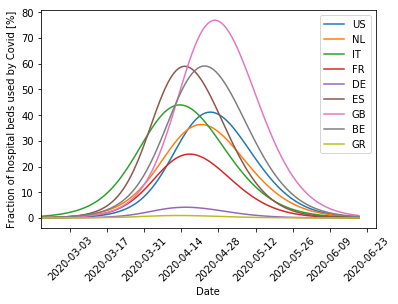

In [15]:
# Experiment with logistics fits to cases as fct of date
# NB predictions are shaky and dangerous! That's why the real epidemiologists don't
# go on record with simple logistics fits...
# Still:
# Use logistics fit to convolve with onset-to-recovery and onset-to-death curves
# Subtract recovery and death curves thus derived from logistics fit to get estimate
# of active cases
# ... then estimate hospitalised cases from active cases using (age-dependent) hospitalisation
# rate from Verity et al. paper above.
# Estimate fraction of used hospital beds in each country
# NB ICU comparison would be more useful but ICU probability not given
# NB Number of hospital beds not given consistently worldwide. Combining data from EUstat
#    with data from wikipeia (of all places!) Caveat emptor!

fig=plt.figure()
ax=fig.add_subplot(111)
i=0;
t=pd.date_range('2020-02-15', '2020-06-20')
tt=t.to_julian_date()-t[0].to_julian_date()
for geoId in Interest:
# for geoId in ['DE', 'US']:
    i+=1

#     ax=fig.add_subplot(np.ceil(len(Interest)/2),2,i)
    startpar=[5,30,max(Ninfections[geoId])]
    pf=df_fit(logistic_raw, Ninfections[geoId], startpar)
    infection_model=logistic(t, pf, geoId)
    fatality_model=signal.convolve(infection_model.values[:,0], CFR[geoId]*pdf_death(tt))[0:len(t)]
    recovered_model=signal.convolve(infection_model.values[:,0], (1-CFR[geoId])*pdf_recovery(tt))[0:len(t)]
    active_model=infection_model.values[:,0]-(fatality_model+recovered_model)
    hospital_model=active_model*HR[geoId]
    
#     infection_model.plot(ax=ax, logy=True)
#     fatality_model.plot(ax=ax, logy=True)
#     recovered_model.plot(ax=ax, logy=True)
#     active_model.plot(ax=ax, logy=True)

    ax.plot(
#          t, infection_model,
#          t, active_model,
         t, hospital_model/Hbeds[geoId]*100,color="C{}".format(i-1)
#          t, recovered_model,
#          t, fatality_model,
#         t[[0,1]],[Hbeds['DE'], Hbeds['DE']]
        )
#     Ninfections[geoId].plot(ax=ax, logy=False, style='.', label=geoId)
#     ax.plot(t[[0,-1]],[Hbeds[geoId], Hbeds[geoId]])
    ax.set_xlim(startdate,)
    ax.set_xlabel("Date")
    ax.set_ylabel("Fraction of hospital beds used by Covid [%]")
    ax.legend(Interest)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# ax.set_ylabel("Total infections with logistic fit")
# ax.grid('on', which='major', axis='y')
# ax.grid('on', which='minor', axis='y', linestyle='dotted')

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp


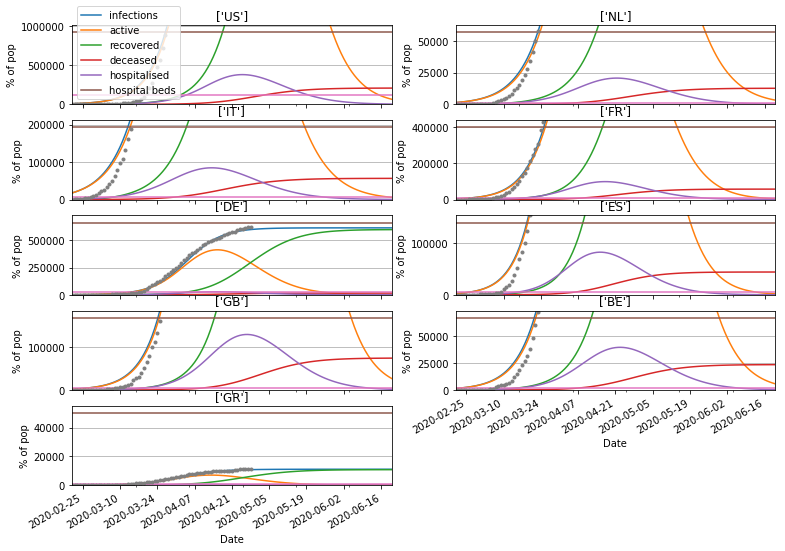

In [21]:
# Experiment with logistics fits to cases as fct of date
# NB predictions are shaky and dangerous! That's why the real epidemiologists don't
# go on record with simple logistics fits...
# Still:
# Use logistics fit to convolve with onset-to-recovery and onset-to-death curves
# Subtract recovery and death curves thus derived from logistics fit to get estimate
# of active cases
# ... then estimate hospitalised cases from active cases using (age-dependent) hospitalisation
# rate from Verity et al. paper above.
# Compare with number of hospital beds in each country
# NB ICU comparison would be more useful but ICU probability not given
# NB Number of hospital beds not given consistently worldwide. Combining data from EUstat
#    with data from wikipeia (of all places!) Caveat emptor!

fig=plt.figure(figsize=(6.3*2,4.7*2))

i=0;
t=pd.date_range('2020-02-15', '2020-06-20')
tt=t.to_julian_date()-t[0].to_julian_date()
for geoId in Interest:
# for geoId in ['DE', 'US']:
    i+=1

    ax=fig.add_subplot(np.ceil(len(Interest)/2),2,i,sharex=ax)
    startpar=[5,30,max(Ninfections[geoId])]
    pf=df_fit(logistic_raw, Ninfections[geoId], startpar)
    infection_model=logistic(t, pf, geoId)
    fatality_model=signal.convolve(infection_model.values[:,0], CFR[geoId]*pdf_death(tt))[0:len(t)]
    recovered_model=signal.convolve(infection_model.values[:,0], (1-CFR[geoId])*pdf_recovery(tt))[0:len(t)]
    active_model=infection_model.values[:,0]-(fatality_model+recovered_model)
    hospital_model=active_model*HR[geoId]
    
#     infection_model.plot(ax=ax, logy=True)
#     fatality_model.plot(ax=ax, logy=True)
#     recovered_model.plot(ax=ax, logy=True)
#     active_model.plot(ax=ax, logy=True)

    ax.plot(
         t, infection_model,
         t, active_model,
         t, recovered_model,
         t, fatality_model,
         t, hospital_model,
        )
    ax.plot(t[[0,-1]],[Hbeds[geoId], Hbeds[geoId]])
    ax.plot(t[[0,-1]],[ICUbeds[geoId], ICUbeds[geoId]])
    Ninfections[geoId].plot(ax=ax, logy=False, style='.', label=geoId)
    ax.set_xlim(startdate,)
    ax.set_ylim(0,Hbeds[geoId]*1.1)
    ax.set_xlabel("Date")
    ax.set_title([geoId])
    if i==1:
        ax.legend([
            'infections',
            'active',
            'recovered',
            'deceased',
            'hospitalised',
            'hospital beds'
        ])
#     if i/2!=np.floor(i/2):
#         ax.set_ylabel('% of pop')
    if i>=len(Interest)-1:
        ax.set_xlabel("Date")
    else:
        ax.set_xticklabels([])
        ax.set_xlabel("")

    ax.set_ylabel('% of pop');
    ax.grid('on', which='major', axis='y')


# ax.set_ylabel("Total infections with logistic fit")
# ax.grid('on', which='major', axis='y')
# ax.grid('on', which='minor', axis='y', linestyle='dotted')